# ANÁLISIS DATOS SUPERMERCADOS

---

(entorno: "coftidypolars" - recrear con "armrequirements.txt")

+ Analizaremos el conjunto de "Supermarket", que se puede conseguir en modo "Open" desde esta dirección:
  + https://datamarket.es/
+ "Productos de supermercados".
+ Este conjunto está en modo "OpenData", aunque puede ocurrir que el acceso requiera su compra.
+ Estos datos son productos descargados de diferentes supermercados de España: Mercadona, Día y Carrefour en el que se indica su precio, nombre, descripción, fecha de alta en base de datos.


![Alt text](charts/Captura%20de%20pantalla%202023-03-25%20a%20las%2021.59.09.png)

---

+ Para realizar este ejercicio,  usaremos una librería de Python que permite usar la potencia de "Polars" que es una nueva forma de trabajar con dataframes de una forma más eficiente que _pandas_ especialmente con conjuntos grandes.
+ Y por encima de _polars_ usaremos una librería que **tidypolars** que se asemeja a _dplyr_ de _R_.
  + Con _tidypolars_ se puede definir un flujo de trabajo en modo _tuberías_ muy fácil de entnder y sencillo de aplicar.
  + Además de _polars_ y de _tidypolars_ tendremos que instalar _pyarrow_ que trabaja con _arrow_ una nueva estructura de intercambio de datos tanto para Python como para R que está teniendo una amplia implantación porque permite trabajar con conjuntos muy grandes de datos de forma equivalente a SQL.
+ Referencias:
  + https://github.com/markfairbanks/tidypolars
  + https://tidypolars.readthedocs.io/en/latest/index.html

---

In [1]:
import tidypolars as tp
from plotnine import *
from tidypolars import *

In [2]:
# Importar el archivo CSV
df = tp.read_csv('./datos/datamarket_productos_de_supermercados_v2.csv')
df.head()


url,supermarket,category,name,description,price,reference_price,reference_unit,insert_date,product_id
str,str,str,str,str,f64,f64,str,str,str
"""https://www.di…","""dia-es""","""alimentacion_c…","""DIA MARI MARIN…",null,1.69,10.83,"""kg""","""2021-03-06 00:…","""2bc67b7f390bea…"
"""https://www.di…","""dia-es""","""mascotas_resto…","""DIA alimento m…",null,1.86,1.86,"""kg""","""2021-03-06 00:…","""7f34f4aa6bc670…"
"""https://www.di…","""dia-es""","""mascotas_resto…","""AS alimento pa…",null,0.78,1.56,"""kg""","""2021-03-06 00:…","""c5e66ddbc123d9…"
"""https://www.di…","""dia-es""","""mascotas_resto…","""DIA barritas c…",null,1.44,22.15,"""kg""","""2021-03-06 00:…","""761110e8dbdf9f…"
"""https://www.di…","""dia-es""","""mascotas_resto…","""DIA barritas c…",null,1.17,18.0,"""kg""","""2021-03-06 00:…","""17c6ba84db051a…"


+ Vemos cuántos tipos de "supermarket" tiene el conjunto:

In [3]:
# Mostrar cuántos elementos diferentes hay en la variable "supermarket"
df.count('supermarket')

supermarket,n
str,u32
"""carrefour-es""",2016071
"""dia-es""",3803682
"""mercadona-es""",3931335


Lo que queremos hacer es poder derterminar qué productos han tenido una mayor variación en precio. 
+ Para ello, seleciconaremos un supermercado: _Mercadona_ por ejemplo.
+ Y añadiremos unas nuevas variables que indique el año_mes.


In [4]:
df = (  
  df
   .mutate(midate = tp.as_datetime(col('insert_date')) )
   .mutate(year = tp.year(col('midate')))
   .mutate(mes = tp.month(col('midate')))
   .mutate(yearmon = col('year')*100 + col('mes'))
)
df.head()

url,supermarket,category,name,description,price,reference_price,reference_unit,insert_date,product_id,midate,year,mes,yearmon
str,str,str,str,str,f64,f64,str,str,str,datetime[μs],i32,u32,i64
"""https://www.di…","""dia-es""","""alimentacion_c…","""DIA MARI MARIN…",null,1.69,10.83,"""kg""","""2021-03-06 00:…","""2bc67b7f390bea…",2021-03-06 00:00:00,2021,3,202103
"""https://www.di…","""dia-es""","""mascotas_resto…","""DIA alimento m…",null,1.86,1.86,"""kg""","""2021-03-06 00:…","""7f34f4aa6bc670…",2021-03-06 00:00:00,2021,3,202103
"""https://www.di…","""dia-es""","""mascotas_resto…","""AS alimento pa…",null,0.78,1.56,"""kg""","""2021-03-06 00:…","""c5e66ddbc123d9…",2021-03-06 00:00:00,2021,3,202103
"""https://www.di…","""dia-es""","""mascotas_resto…","""DIA barritas c…",null,1.44,22.15,"""kg""","""2021-03-06 00:…","""761110e8dbdf9f…",2021-03-06 00:00:00,2021,3,202103
"""https://www.di…","""dia-es""","""mascotas_resto…","""DIA barritas c…",null,1.17,18.0,"""kg""","""2021-03-06 00:…","""17c6ba84db051a…",2021-03-06 00:00:00,2021,3,202103


In [5]:
df.names

['url',
 'supermarket',
 'category',
 'name',
 'description',
 'price',
 'reference_price',
 'reference_unit',
 'insert_date',
 'product_id',
 'midate',
 'year',
 'mes',
 'yearmon']

+ Ahora que tenemos añadidas estas dos columnas, vamos a trabajar solo con el conjunto de "Mercadona", aunque luego lo que encontremos lo extenderemos al resto de supermercados.

In [6]:
mercadf = df.filter(col('supermarket') == 'mercadona-es')
mercadf.head()

url,supermarket,category,name,description,price,reference_price,reference_unit,insert_date,product_id,midate,year,mes,yearmon
str,str,str,str,str,f64,f64,str,str,str,datetime[μs],i32,u32,i64
"""https://tienda…","""mercadona-es""","""mascotas_gato""","""Paté gato adul…","""Tarrina""",0.35,3.5,"""kg""","""2021-03-06 00:…","""7770dabf173230…",2021-03-06 00:00:00,2021,3,202103
"""https://tienda…","""mercadona-es""","""mascotas_gato""","""Paté gato adul…","""Tarrina""",0.35,3.5,"""kg""","""2021-03-06 00:…","""e9fe0e0f0fdfb0…",2021-03-06 00:00:00,2021,3,202103
"""https://tienda…","""mercadona-es""","""mascotas_gato""","""Paté gato adul…","""Tarrina""",0.35,3.5,"""kg""","""2021-03-06 00:…","""9cfdc816b7df65…",2021-03-06 00:00:00,2021,3,202103
"""https://tienda…","""mercadona-es""","""mascotas_gato""","""Paté gato adul…","""Bote""",0.65,1.63,"""kg""","""2021-03-06 00:…","""be1b012e7ee9ab…",2021-03-06 00:00:00,2021,3,202103
"""https://tienda…","""mercadona-es""","""mascotas_gato""","""Paté gato adul…","""Bote""",0.65,1.63,"""kg""","""2021-03-06 00:…","""1eea77f457b08b…",2021-03-06 00:00:00,2021,3,202103


In [7]:
mercadf.nrow

3931335

+ Este conjunto tiene aprox. 4M de elementos.

+ Y ...¿cuántos productos se detallan en este subconjunto de _Mercadona_.
+ Pero tenemos que tener en cuenta que como productos diferentes tenemos que considerar la unión de _name_ y _description_. 
  + Vemos que para las "Paté gato.." tenemos diferentes descripciones con valores de precio también diferentes.
+ Creamos por tanto esta nueva variable.

In [8]:
mercadf = (
    mercadf
    .mutate( namedesc = paste(col('name'), col('description'), sep = '_'))
)
val = mercadf.select(col('namedesc')).head(1)
val.head()

namedesc
str
"""Paté gato adul…"


In [9]:
numprod = mercadf.count(col('namedesc'))
numprod.nrow

8142

In [10]:
numprod.head()

namedesc,n
str,u32
"""Solomillo de p…",624
"""Bolas de cerea…",672
"""Agua mineral p…",267
"""Cepillo dental…",287
"""Compresa sin a…",129


+ Ordenamos de mayor a menor el por número de veces que aparece el producto en el conjunto.

In [11]:
numprod.arrange(tp.desc('n')).head(20)

namedesc,n
str,u32
null,366931
"""Huevos grandes…",2016
"""Zumo de naranj…",2016
"""Refresco Coca-…",2016
"""Leche condensa…",2011
"""Leche entera H…",2001
"""Cerveza Clásic…",1999
"""Leche semidesn…",1990
"""Leche semidesn…",1982


+ Para el estudio que queremos hacer de variación de precios, podemos tomar la decisión de quedarnos solo con aquellos productos que tengan un número de entradas superior a 1000 por ejemplo. No tiene sentido analizar conjuntos con pocas entradas.
+ Añadiremos ese valor del número de entradas al conjunto de _Mercadona_ y aplicaremos un filtro.
+ Y en el filtro aprovecharemos para eliminar los elementos que vemos que tienen valor nulo en la descripción.

In [12]:
mercadf = (
    mercadf
    .mutate(qty_prod = tp.n(), by = 'namedesc' )
)
mercadf.names

['url',
 'supermarket',
 'category',
 'name',
 'description',
 'price',
 'reference_price',
 'reference_unit',
 'insert_date',
 'product_id',
 'midate',
 'year',
 'mes',
 'yearmon',
 'namedesc',
 'qty_prod']

In [13]:
mercadfred = (
    mercadf
    .filter( col('qty_prod') >= 1000 )
    .filter( str_length(col('namedesc')) > 1)
)
mercadfred.nrow

174541

+ El cojunto se reduce notablemente a 174k filas de las casi 4M iniciales.

+ ¿Con cuántos productos nos hemos quedado?.

In [14]:
prodorder = mercadfred.count(col('namedesc')).arrange(tp.desc('n'))
prodorder.nrow

130

+ El resultado de aplicar estos filtros es que nos hemos quedado con *130* productos diferentes.
+ Es interesante ver que uno de los productos con mayor presencia en el conjunto, es el de "Huevos grandes..." que al ser un producto de alta necesidad, nos va a permitir estudiar la variación de sus precios.

In [15]:
mercadfred.head()

url,supermarket,category,name,description,price,reference_price,reference_unit,insert_date,product_id,midate,year,mes,yearmon,namedesc,qty_prod
str,str,str,str,str,f64,f64,str,str,str,datetime[μs],i32,u32,i64,str,u32
"""https://tienda…","""mercadona-es""","""bebe_higiene_y…","""Agua de coloni…","""Bote""",1.45,1.45,"""100ml""","""2021-03-06 00:…","""e6bc65905ad133…",2021-03-06 00:00:00,2021,3,202103,"""Agua de coloni…",1331
"""https://tienda…","""mercadona-es""","""bebe_higiene_y…","""Agua de coloni…","""Bote""",2.05,0.34,"""100ml""","""2021-03-06 00:…","""7c7b8f0ea668c0…",2021-03-06 00:00:00,2021,3,202103,"""Agua de coloni…",1331
"""https://tienda…","""mercadona-es""","""bebe_higiene_y…","""Agua de coloni…","""Bote""",1.45,1.45,"""100ml""","""2021-03-07 00:…","""e6bc65905ad133…",2021-03-07 00:00:00,2021,3,202103,"""Agua de coloni…",1331
"""https://tienda…","""mercadona-es""","""bebe_higiene_y…","""Agua de coloni…","""Bote""",2.05,0.34,"""100ml""","""2021-03-07 00:…","""7c7b8f0ea668c0…",2021-03-07 00:00:00,2021,3,202103,"""Agua de coloni…",1331
"""https://tienda…","""mercadona-es""","""bebe_higiene_y…","""Agua de coloni…","""Bote""",1.45,1.45,"""100ml""","""2021-03-08 00:…","""e6bc65905ad133…",2021-03-08 00:00:00,2021,3,202103,"""Agua de coloni…",1331


In [16]:
mercadfred.names

['url',
 'supermarket',
 'category',
 'name',
 'description',
 'price',
 'reference_price',
 'reference_unit',
 'insert_date',
 'product_id',
 'midate',
 'year',
 'mes',
 'yearmon',
 'namedesc',
 'qty_prod']

+ Queremos calcular para cada producto _name_desc_, el valor que tuvo en el mínimo de _yearmon_.
+ Y el valor que tuvo para el máximo de _yearmon_.

In [17]:
prod_min = (
    mercadfred
    .mutate( minyear = tp.min('yearmon'), by = 'namedesc')
    .select( col('namedesc'), col('minyear'), col('price'))
    .distinct()
)
prod_min.head()

namedesc,minyear,price
str,i64,f64
"""Preparado láct…",202103,6.0
"""Preparado láct…",202103,1.55
"""Preparado láct…",202103,6.6
"""Preparado láct…",202103,1.65
"""Preparado láct…",202103,7.2


+ El problema que vemos es que para el mismo producto y en el mismo año tenemos diferentes valores. 
+ El origen de este problema es que cada producto tiene un "product_id", es realmente este el campo por el que tenemos que hacer todas las agrupaciones que hemos hecho hasta ahora.
+ Lo repetimos en la siguiente instrucción.

In [18]:
mercadf = (
    mercadf
    .mutate(qty_prod = tp.n(), by = 'product_id' )
    .arrange(tp.desc('qty_prod'))
)
mercadf.head()

url,supermarket,category,name,description,price,reference_price,reference_unit,insert_date,product_id,midate,year,mes,yearmon,namedesc,qty_prod
str,str,str,str,str,f64,f64,str,str,str,datetime[μs],i32,u32,i64,str,u32
"""https://tienda…","""mercadona-es""","""cereales_y_gal…","""Tortitas de ma…","""Paquete""",1.5,11.54,"""kg""","""2021-03-06 00:…","""9674a678fd583d…",2021-03-06 00:00:00,2021,3,202103,"""Tortitas de ma…",672
"""https://tienda…","""mercadona-es""","""cereales_y_gal…","""Tortitas de ma…","""Paquete""",1.5,11.54,"""kg""","""2021-03-07 00:…","""9674a678fd583d…",2021-03-07 00:00:00,2021,3,202103,"""Tortitas de ma…",672
"""https://tienda…","""mercadona-es""","""cereales_y_gal…","""Tortitas de ma…","""Paquete""",1.5,11.54,"""kg""","""2021-03-08 00:…","""9674a678fd583d…",2021-03-08 00:00:00,2021,3,202103,"""Tortitas de ma…",672
"""https://tienda…","""mercadona-es""","""cereales_y_gal…","""Tortitas de ma…","""Paquete""",1.5,11.54,"""kg""","""2021-03-09 00:…","""9674a678fd583d…",2021-03-09 00:00:00,2021,3,202103,"""Tortitas de ma…",672
"""https://tienda…","""mercadona-es""","""cereales_y_gal…","""Tortitas de ma…","""Paquete""",1.5,11.54,"""kg""","""2021-03-10 00:…","""9674a678fd583d…",2021-03-10 00:00:00,2021,3,202103,"""Tortitas de ma…",672


In [19]:
mercadfred = (
    mercadf
    .filter( col('qty_prod') >= 100 )
    .filter( str_length(col('namedesc')) > 1)
)
mercadfred.nrow

3520349

In [20]:
prodorder = mercadfred.count(col('product_id')).arrange(tp.desc('n'))
prodorder.nrow

7056

+ Ahora vamos a extraer para para cada "product_id" el año/mes mínimo (cuando fue introducido en la lista).
+ Y escogeremos la fila en la que "yearmon" es igual al valor de "minyear". 
+ Ordenamos la salida por "product_id" y ese año mínimo.

In [21]:
prod_min = (
    mercadfred
    .mutate( minyear = tp.min('yearmon'), by = 'product_id')
    .mutate( isminyear = tp.if_else(col('yearmon') == col('minyear'), 1, 0))
    .filter( col('isminyear') == 1)
    .select( col('namedesc'), col('product_id'), col('minyear'), col('price'), col('qty_prod'))
    .distinct()
    .arrange(col('product_id'), tp.desc('minyear'), col('price'))
)
prod_min.head()

namedesc,product_id,minyear,price,qty_prod
str,str,i64,f64,u32
"""Comprimidos Vi…","""000d8079b6a0da…",202201,4.0,356
"""Patatas bravas…","""00150166e7c5c1…",202209,1.45,112
"""Baño de color …","""0015c4bf6eb2d4…",202107,4.6,551
"""Mini eau de pa…","""0023b050194a9f…",202103,1.5,139
"""Queso rallado …","""002c7f51dd28e4…",202204,1.4,270


+ Vemos que para cada name/product y "product_id" puede haber varias entradas, que pueden corresponder a diferentes días del mes.
+ Como aproximación cogeremos el mínimo del mes en el precio. Aunque podríamos generar una nueva variable con el día añadido a la fecha y coger el día mínimo igualmente.
+ Del conjunto anterior, para cada "product_id" como está ordenado por "product_id" y "minyear", cogeríamos el primer elemento.
+ Cambiamos el nombre del "price" a "price_min".

In [22]:
prodmin_gd = (
    prod_min
    .slice_head(1, by = 'product_id')
    .arrange(tp.desc('qty_prod'))
    .rename( price_min = 'price')
)
prodmin_gd.head()

namedesc,product_id,minyear,price_min,qty_prod
str,str,i64,f64,u32
"""Barritas de ce…","""f3d5316604b0ca…",202103,0.97,672
"""Queso blando P…","""856f9c82b08003…",202103,2.38,672
"""Queso manchego…","""289bbc78a68bfc…",202103,4.55,672
"""Trucha sin ale…","""3203e4120c3460…",202103,3.45,672
"""Cerveza Heinek…","""0ba00d7bd552f1…",202103,0.66,672


+ Y ahora hacemos lo mismo para el precio del último mes (el máximo mes) en el que el producto entró en la lista.

In [23]:
prod_max = (
    mercadfred
    .mutate( maxyear = tp.max('yearmon'), by = 'product_id')
    .mutate( ismaxyear = tp.if_else(col('yearmon') == col('maxyear'), 1, 0))
    .filter( col('ismaxyear') == 1)
    .select( col('namedesc'), col('product_id'), col('maxyear'), col('price'), col('qty_prod'))
    .distinct()
    .arrange(col('product_id'), tp.desc('maxyear'), col('price'))
)
prod_max.head()

prodmax_gd = (
    prod_max
    .slice_head(1, by = 'product_id')
    .arrange(tp.desc('qty_prod'))
    .rename( price_max = 'price')
)
prodmax_gd.head()

namedesc,product_id,maxyear,price_max,qty_prod
str,str,i64,f64,u32
"""Refresco de li…","""9575aa5c97af7c…",202301,2.1,672
"""Ambientador co…","""3c4fbd64c4375d…",202301,1.85,672
"""Recambios reca…","""599ed3a565f5e0…",202301,3.15,672
"""Cápsulas contr…","""9def5af6e14252…",202301,4.5,672
"""Zumo de naranj…","""63c05c6e32a1b8…",202301,1.59,672


+ Ahora tenemos que juntar los dos dataframes por "product_id" y "namedesc" y así tendremos el "price_min" y el "price_max".

In [24]:
dfminmax = (
    prodmin_gd.left_join(prodmax_gd, left_on = [ 'namedesc','product_id'], right_on = ['namedesc','product_id'])
)
dfminmax

namedesc,product_id,minyear,price_min,qty_prod,maxyear,price_max,qty_prod_right
str,str,i64,f64,u32,i64,f64,u32
"""Barritas de ce…","""f3d5316604b0ca…",202103,0.97,672,202301,1.0,672
"""Queso blando P…","""856f9c82b08003…",202103,2.38,672,null,null,null
"""Queso manchego…","""289bbc78a68bfc…",202103,4.55,672,null,null,null
"""Trucha sin ale…","""3203e4120c3460…",202103,3.45,672,202301,3.57,672
"""Cerveza Heinek…","""0ba00d7bd552f1…",202103,0.66,672,202301,0.82,672
"""Refresco té co…","""746edeeb5f3e5f…",202103,1.3,672,202301,1.3,672
"""Mozzarella di …","""3da1a7b2bede9b…",202103,1.7,672,202301,1.73,672
"""Pan de hamburg…","""70d3037ce88a9d…",202103,0.85,672,202301,1.0,672
"""Limpiador de p…","""77b4379c0316e8…",202103,2.9,672,null,null,null


+ Observamos varias cosas:
    + Que tenemos valores de _maxyear_ que son nulos. Seguramente porque la fecha no estaba bien y no se pudo calcular el año y el mes. Estas columnas las tendremos que quitar.
    + Que podemos calcular el porcentaje de variación entre el _precio_max_ (que es el precio en el máximo del meses) y el _price_min_ (el precio en el año/mes mínimo).

+ El resultado lo ordenaremos de mayor a menor, el porcentaje de variación.

In [25]:
dfminmax_end = (
    dfminmax
    .filter(tp.is_not_null(col('maxyear')))
    .mutate(deltaprice = tp.round((col('price_max') - col('price_min'))*100/ col('price_min'),2))
    .arrange(tp.desc('deltaprice'))
)
dfminmax_end.head(15)

namedesc,product_id,minyear,price_min,qty_prod,maxyear,price_max,qty_prod_right,deltaprice
str,str,i64,f64,u32,i64,f64,u32,f64
"""Fresón_Bandeja…","""b724a364b3e88b…",202103,1.25,240,202301,3.84,240,207.2
"""Magdalenas Hac…","""715d7fbc160446…",202103,0.95,467,202206,2.35,467,147.37
"""Filtros de caf…","""68711f1e69118e…",202103,0.79,672,202301,1.95,672,146.84
"""Bicarbonato só…","""10fde44161d8af…",202103,0.45,672,202301,1.1,672,144.44
"""Comino en gran…","""d1f58d4efd83db…",202103,0.8,662,202301,1.95,662,143.75
"""Croissant Hace…","""baca7ed2421573…",202106,0.95,310,202205,2.2,310,131.58
"""Caballa Verdel…","""c877dbc4e0ea0f…",202103,1.22,156,202207,2.74,156,124.59
"""Caballa Verdel…","""7ee40872976441…",202103,1.22,156,202207,2.74,156,124.59
"""Caballa Verdel…","""5e1d9f30a0cba4…",202103,1.22,156,202207,2.74,156,124.59


+ Finalmente obtenemos resultados de interés.
+ Hay productos que han tenido variación del 200% (_Fresón_) y en los top-15, tenemos variaciones superiores al 115%. O las "Magdalenas Hacendado" que han tenido una variación de 147% en un año.

+ Ahora lo que podemos hacer es representar gráficamente la variación en el tiempo de alguno de estos productos con alta variación de precios.
+ Escogeremos los cinco primeros productos de la lista anterior para representarles.

In [26]:
top5list = (
   dfminmax_end
   .select('product_id') 
   .slice_head(5)
   .pull('product_id')
)
top5list

product_id
str
"""b724a364b3e88b…"
"""715d7fbc160446…"
"""68711f1e69118e…"
"""10fde44161d8af…"
"""d1f58d4efd83db…"


+ Extraemos las filas que cumplen que el "product_id" coincide con esta lista de top-5 variaciones.
+ Del dataframe extraeremos el "product_id" el "namedesc", "yearmon" y el "price"

In [27]:
top5df = (
    mercadf
    .filter(tp.is_in(col('product_id'), top5list))
    .select('product_id', 'namedesc', 'yearmon', 'price')
    .arrange(col('product_id'), col('yearmon'))
    .distinct()
)
top5df.head()

product_id,namedesc,yearmon,price
str,str,i64,f64
"""10fde44161d8af…","""Bicarbonato só…",202103,0.45
"""10fde44161d8af…","""Bicarbonato só…",202104,0.45
"""10fde44161d8af…","""Bicarbonato só…",202105,0.45
"""10fde44161d8af…","""Bicarbonato só…",202106,0.45
"""10fde44161d8af…","""Bicarbonato só…",202107,0.45


+ Para poder pintar hay que convertir este dataframe en un objeto de _pandas_.
+ Y luego usaremos "plotnine" para su representación.

In [28]:
top5df = top5df.to_pandas()
top5df.head(10)

,product_id,namedesc,yearmon,price
0,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202103,0.45
1,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202104,0.45
2,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202105,0.45
3,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202106,0.45
4,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202107,0.45
5,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202108,0.45
6,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202109,0.45
7,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202110,0.45
8,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202111,0.45
9,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202112,0.45


In [29]:
import plotnine
from plotnine import *
import datar
from datar.all import *


[2024-07-22 13:24:50][datar][WARNING] Builtin name "re" has been masked by datar.


[2024-07-22 13:24:50][datar][WARNING] Builtin name "sum" has been masked by datar.


[2024-07-22 13:24:50][datar][WARNING] Builtin name "all" has been masked by datar.


[2024-07-22 13:24:50][datar][WARNING] Builtin name "max" has been masked by datar.


[2024-07-22 13:24:50][datar][WARNING] Builtin name "round" has been masked by datar.


[2024-07-22 13:24:50][datar][WARNING] Builtin name "abs" has been masked by datar.


[2024-07-22 13:24:50][datar][WARNING] Builtin name "filter" has been masked by datar.


[2024-07-22 13:24:50][datar][WARNING] Builtin name "any" has been masked by datar.


[2024-07-22 13:24:50][datar][WARNING] Builtin name "slice" has been masked by datar.


[2024-07-22 13:24:50][datar][WARNING] Builtin name "min" has been masked by datar.


In [30]:
top5df = (
    top5df
    >> mutate(yearmonfct = as_factor(f.yearmon))
)
top5df

,product_id,namedesc,yearmon,price,yearmonfct
,<object>,<object>,<int64>,<float64>,<category>
0,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202103,0.45,202103
1,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202104,0.45,202104
2,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202105,0.45,202105
3,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202106,0.45,202106
...,...,...,...,...,...
4,10fde44161d8af883ac0649569fb47b0,Bicarbonato sódico Hacendado_Bote,202107,0.45,202107
120,d1f58d4efd83db6b6b0e3831b13c80c9,Comino en grano Hacendado_Bote,202210,1.55,202210
121,d1f58d4efd83db6b6b0e3831b13c80c9,Comino en grano Hacendado_Bote,202211,1.55,202211
122,d1f58d4efd83db6b6b0e3831b13c80c9,Comino en grano Hacendado_Bote,202212,1.55,202212


/Users/carlosortega/miniconda3/envs/coftidypolars/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


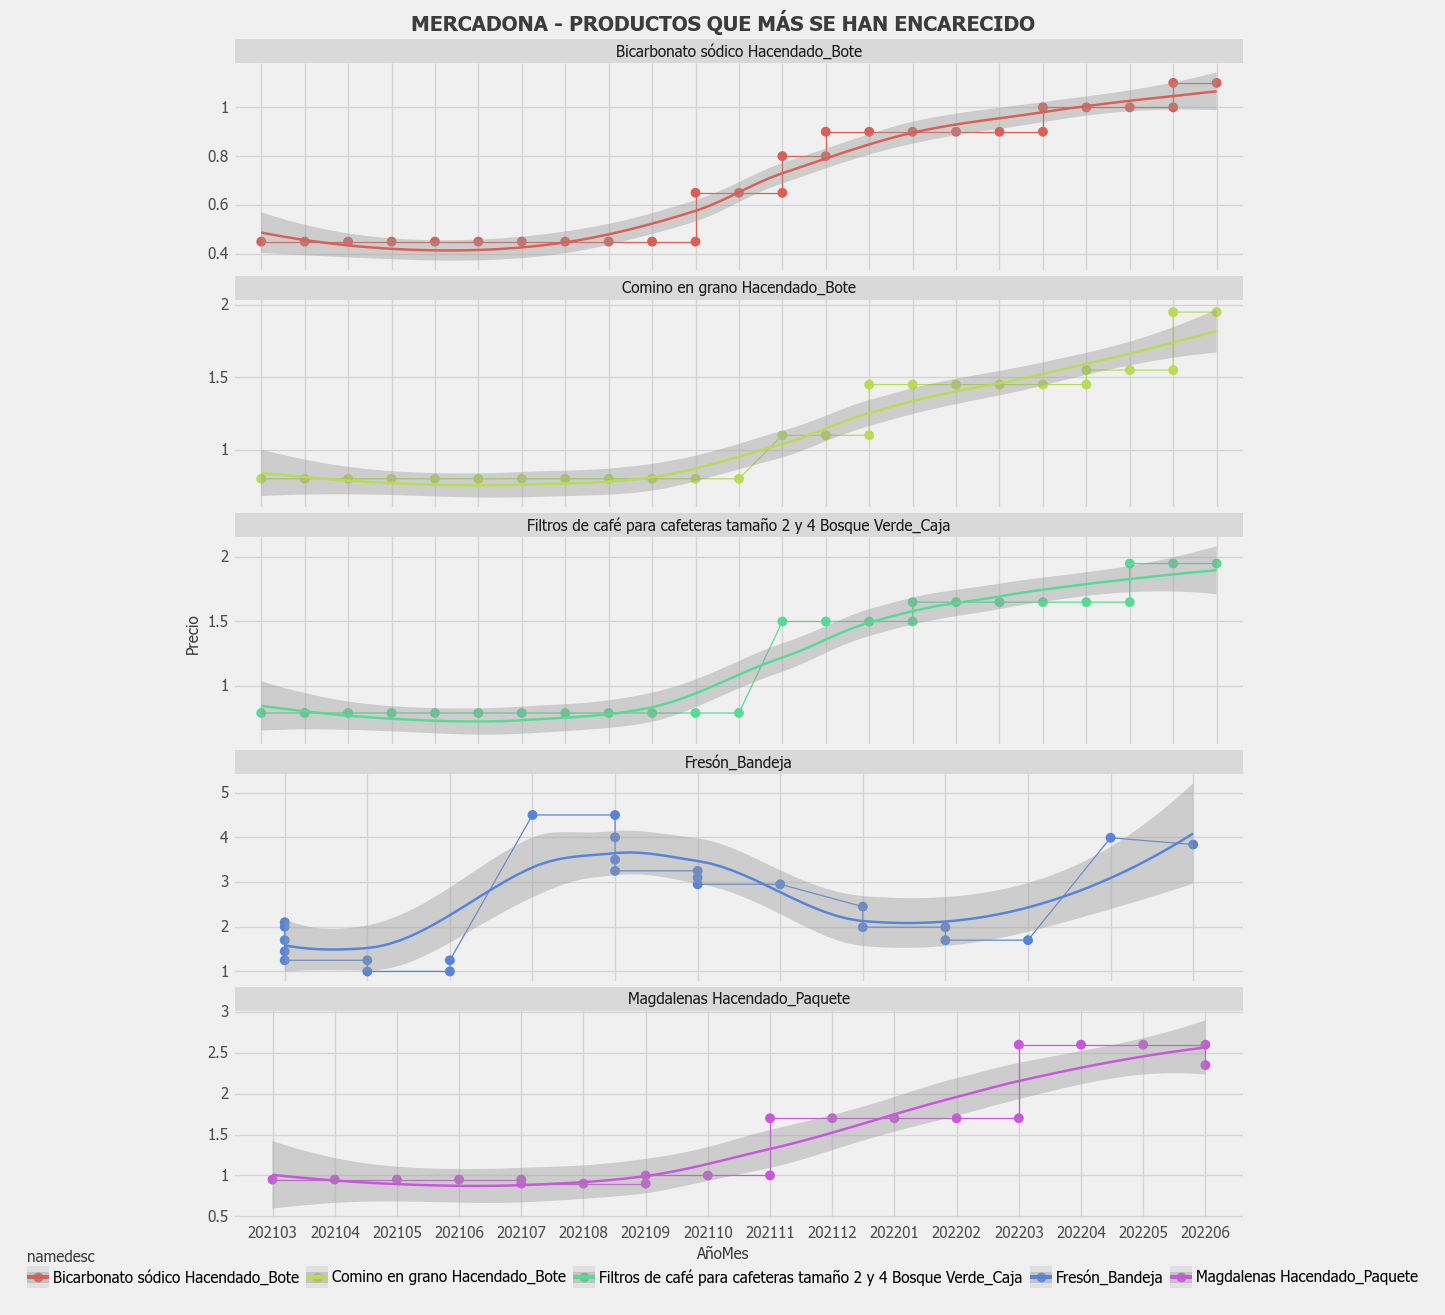

<ggplot: (876011999)>

In [31]:
import plotnine
plotnine.options.figure_size=(13, 15)

(
    ggplot(top5df, aes(x = 'yearmonfct', y = 'price', group = 'namedesc', color = 'namedesc'))
    + geom_point(size = 3)
    + geom_line()
    + stat_smooth()
    + ggtitle("MERCADONA - PRODUCTOS QUE MÁS SE HAN ENCARECIDO")
    + xlab("AñoMes")
    + ylab("Precio")
    + facet_wrap('namedesc', nrow = 5, scales = 'free')
    + theme_538()
    + theme(
        axis_text_x=element_text(angle=0),
        legend_position="bottom",
        legend_direction="horizontal",
        text=element_text(family="Tahoma", size=11),
        plot_title=element_text(size=15, family="Tahoma", face="bold")
        #legend_title=element_blank()
    )
)

---

+ Ahora podemos ver cómo se puede hacer esta mismo enfoque usando R y el paquete _tidytable_ que combina la posibilidad de trabajar con data.table (paquete muy optimizado para conjuntos grandes y alta velocidad) y la opción de usar tuberías (como las que proporciona _dplyr_). 

In [32]:
%load_ext rpy2.ipython

Error en file(filename, "r", encoding = encoding): 
  no se puede abrir la conexión
Además: Aviso:
In file(filename, "r", encoding = encoding) :
  no fue posible abrir el archivo '/Users/carlosortega/.vscode/extensions/reditorsupport.r-2.8.2/R/session/init.R': No such file or directory
Error en file(filename, "r", encoding = encoding): 
  no se puede abrir la conexión
Además: Aviso:
In file(filename, "r", encoding = encoding) :
  no fue posible abrir el archivo '/Users/carlosortega/.vscode/extensions/reditorsupport.r-2.8.2/R/session/init.R': No such file or directory


In [33]:
%%R

#--- Load libraries
suppressPackageStartupMessages({
library(data.table)
library(tidytable)
library(ggplot2)
library(tictoc)
library(janitor)
library(magrittr)
library(lubridate)
library(ggeasy)
})

#--- Clean environment
inv_gc()
inv_gc()

tini <- Sys.time()

#--- Read Data
tic()
midir <- './datos/'

mifile <- 'datamarket_productos_de_supermercados_v2.csv'
datos  <- fread(paste(midir, mifile, sep = "")) %>% as.data.table()
toc(func.toc = toc.outmsg)
# 16.18 sec elapsed

print(object.size(datos), units = "auto")
# 760.5 Mb


In [ ]:
%%R

#--- Calculations
# Cuantos supermercados..
datos %>% count.(supermarket)

# # A tidytable: 3 × 2
# supermarket        n
# <chr>          <int>
# 1 carrefour-es 2013216
# 2 dia-es       3798230
# 3 mercadona-es 3926129

#--- Veamos Mercadona
#--- Número de referencias.
datos %>% 
  filter(supermarket == "mercadona-es") %>%
  count(name) %>%
  arrange(-n) %>%
  as.data.table()

#-- Solo Mercadona
mercadf <- datos %>%
  filter(supermarket == "mercadona-es") %>%
  mutate(yearmon = year(insert_date) * 100 + month(insert_date)) %>%
  as.data.table()

# > nrow(mercadf)
# [1] 3931335

#--- Create max prices and min prices.
tic()
mercadfmin <- mercadf %>%
  mutate(minyearmon = min(yearmon), .by = product_id) %>%
  mutate(pricemin = ifelse(minyearmon == yearmon, 'Min', 'No'), .by = product_id) %>%
  filter(pricemin == "Min") %>%
  select(product_id, category, name, price, minyearmon, pricemin) %>%
  arrange(product_id, minyearmon, price) %>%
  rename(price_min = price) %>%
  slice_head(n = 1, .by = c(product_id, minyearmon)) %>%
  distinct() %>%
  setkey(product_id) %>%
  as.data.table()
  
mercadfmax <- mercadf %>%  
  mutate(maxyearmon = max(yearmon), .by = product_id) %>%
  mutate(pricemax = ifelse(maxyearmon == yearmon, 'Max', 'No'), .by = product_id) %>%
  filter(pricemax == "Max") %>%
  select(product_id, category, name, price, maxyearmon, pricemax) %>%
  arrange(product_id, maxyearmon, -price) %>%
  rename(price_max = price) %>%
  slice_head(n = 1, .by = c(product_id, maxyearmon)) %>%
  distinct() %>%
  setkey(product_id) %>%
  as.data.table()
toc(func.toc = toc.outmsg)
# 1.151 sec elapsed


#--- Merge both datasets to get max and min values for the same product_id
mercadfend <- mercadfmin %>%
  left_join(mercadfmax, by = c('product_id')) %>%
  select(-category.y, -name.y) %>%
  mutate( delta = round( (price_max - price_min)*100/price_min, 2)) %>%
  arrange(-delta) %>%
  as.data.table()

#--- Top - 10
top10 <- mercadfend %>%
  select(product_id) %>%
  distinct() %>%
  slice_head(n = 12) %>%
  pull(product_id)

#--- Extract top-10 from Mercadona df
mercatop10 <- mercadf %>%
  filter( product_id %chin% top10) %>%
  mutate(prod_name = paste(name, description, sep = "_")) %>%
  select(product_id, prod_name, yearmon, price) %>%
  arrange(product_id, prod_name, yearmon, price) %>%
  slice_head(n = 1, .by = c(product_id, yearmon)) %>%
  distinct() %>%
  as.data.table()

#---- END OF FILE --------------
tend <- Sys.time(); tend - tini
# Time difference of 27.48517 secs

In [ ]:
%%R -w 900 -h 650 -r 100

#---- Chart each product evolution
options( repr.plot.width = 13, repr.plot.height = 15)

merca_gr <- ggplot(mercatop10, aes( x = as.factor(yearmon), y = price, group = prod_name, color = prod_name)) +
  geom_point() +
  geom_line() +
  facet_wrap(~ prod_name, scales = 'free') +
  labs(
    title = "TOP PRODUCTOS MÁXIMA VARIACION EN PRECIOS",
    x = "AñoMes",
    y = "Precio (€)"
  ) +
  theme_bw() +
  theme(
         strip.text = element_text(size = 6, face = "bold"),
         strip.background = element_rect(fill = "white")
       ) +
  easy_rotate_x_labels(angle = 90, side = c('middle')) +
  easy_x_axis_labels_size(size = 4) +
  easy_legend_at( to = "none" )
print(merca_gr)
ggsave("./Top_product_with_increment_price.png")

#---- END OF FILE --------------
tend <- Sys.time(); tend - tini
# Time difference of 27.48517 secs